In [ ]:
!pip install prophet --no-cache
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet
import numpy as np
import pandas as pd

In [12]:
df = pd.read_excel('/content/drive/MyDrive/demand forcasting/online_retail_II.xlsx')

df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


In [13]:
df.shape

(525461, 8)

In [14]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [15]:
#droping
df = df.dropna(subset=['Description', 'Customer ID'])

In [16]:

# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# Create a new DataFrame with 'ds' and 'y' columns
data = df[['InvoiceDate', 'Quantity']].rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})
#remove rows with o y value for future analysis
data = data[data['y'] != 0]

In [17]:
# checking our date

earliest_date = df['InvoiceDate'].min()
latest_date = df['InvoiceDate'].max()

diffrence = latest_date -earliest_date

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)
print(diffrence)

Earliest Date: 2009-12-01
Latest Date: 2010-12-09
373 days, 0:00:00


<Axes: >

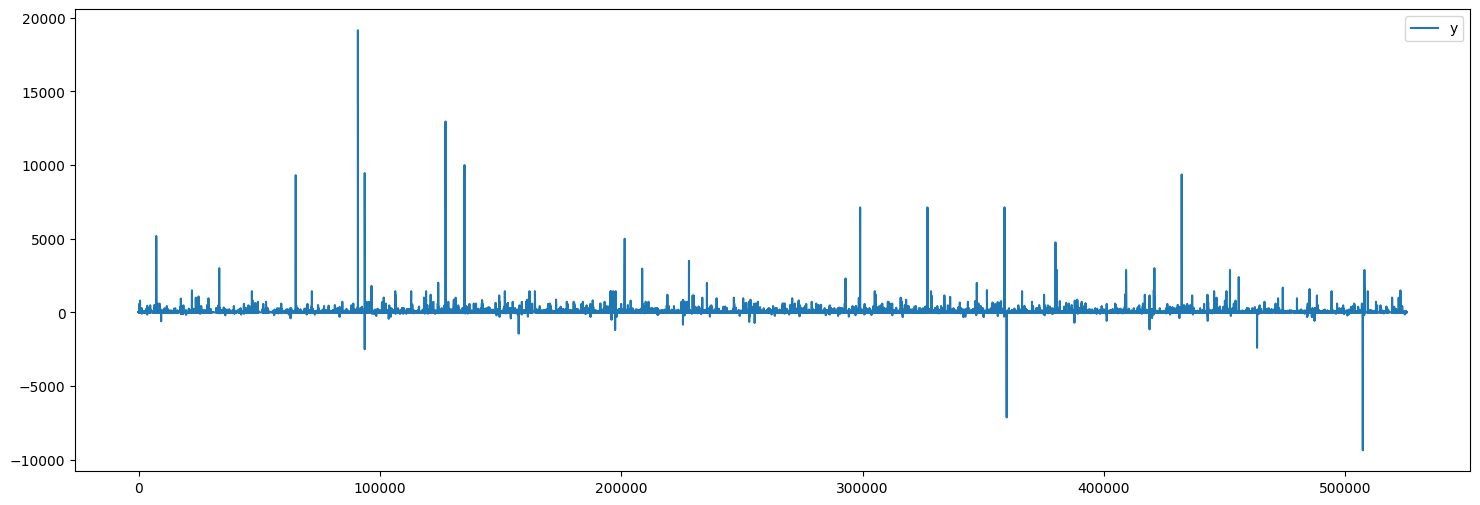

In [18]:
#plot
data.plot(figsize =(18,6))

In [21]:

data.dropna(subset=['y'], inplace=True)
data = data[data['y'] != 0]
data['y'] = np.log(data['y'])
print(data.head(4))

           ds         y
0  2009-12-01 -0.094052
1  2009-12-01 -0.094052
2  2009-12-01 -0.094052
3  2009-12-01  0.302742


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

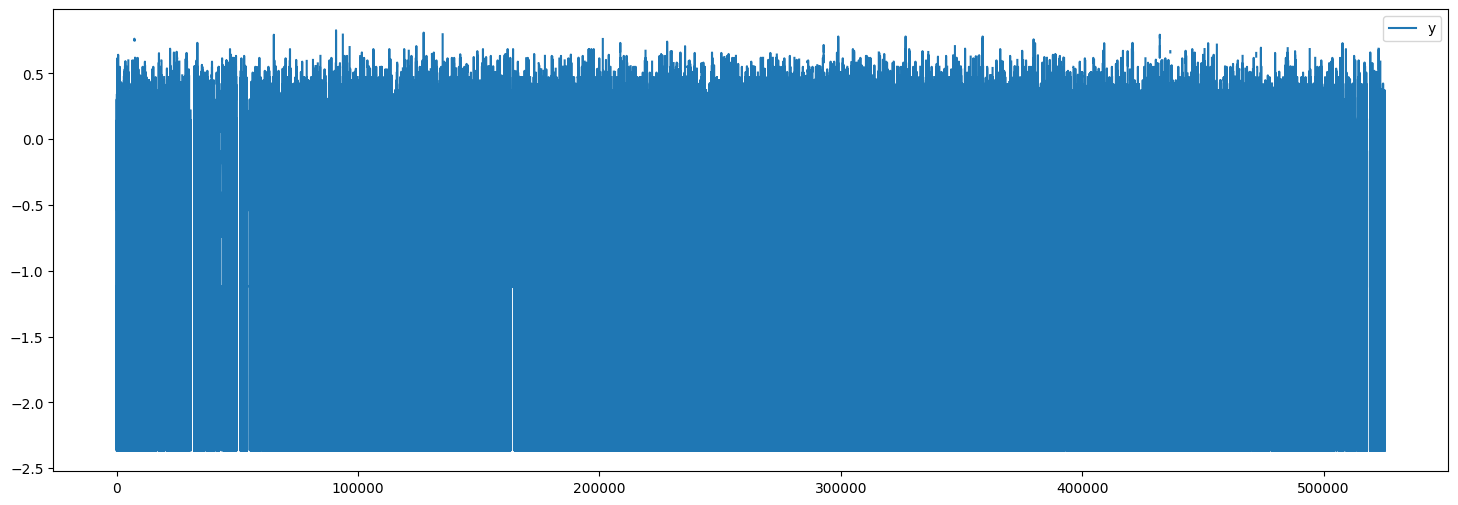

In [22]:
#plot  again
data.plot(figsize =(18,6))

In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to the data
model.fit(data)


In [24]:
future_periods = 365  # Number of periods to forecast into the future
future = model.make_future_dataframe(periods=future_periods)

In [25]:
#prediction
forecast = model.predict(future)

In [26]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(4)

,ds,yhat,yhat_lower,yhat_upper
0,2009-12-01,-0.491181,-1.452928,0.477535
1,2009-12-02,-0.483342,-1.440112,0.542617
2,2009-12-03,-0.526717,-1.501839,0.402663
3,2009-12-04,-0.465916,-1.509101,0.522236


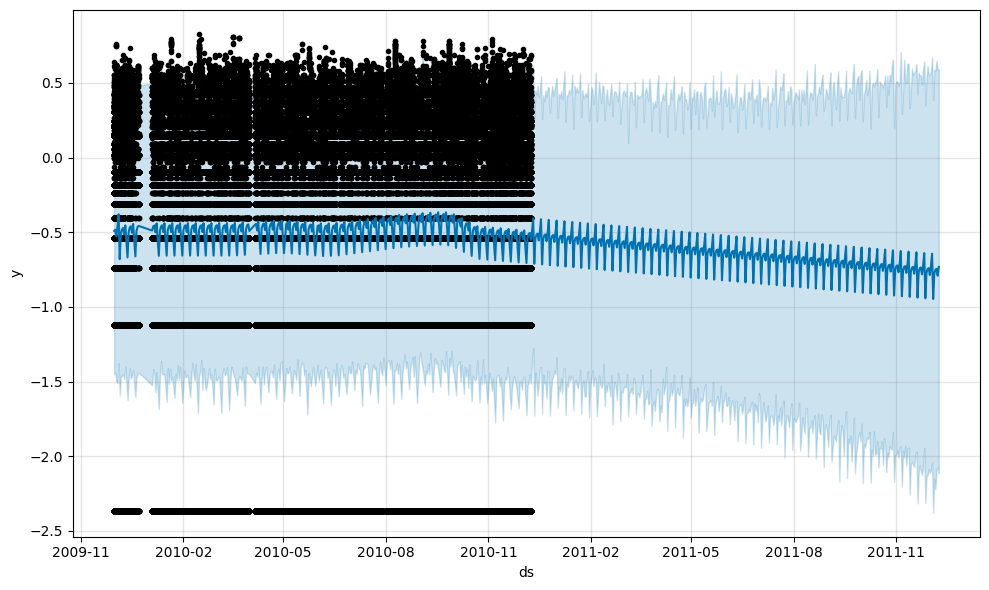

In [27]:
#ploting our forcast
fig1 = model.plot(forecast)


In [28]:
plot_components_plotly(model,forecast)

#Cross validation for better accuracy

In [29]:
# use cross validation for better performance
df_cv = cross_validation(model, initial='273 days', period='50 days', horizon = '100 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2010-08-31 00:00:00 and 2010-08-31 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnbr_cjh5/4km3nukj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnbr_cjh5/okoxjhry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64907', 'data', 'file=/tmp/tmpnbr_cjh5/4km3nukj.json', 'init=/tmp/tmpnbr_cjh5/okoxjhry.json', 'output', 'file=/tmp/tmpnbr_cjh5/prophet_model0x62uung/prophet_model-20230616094629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-09-01,-0.377686,-1.294029,0.635714,-0.094052,2010-08-31
1,2010-09-01,-0.377686,-1.348149,0.588575,-0.539228,2010-08-31
2,2010-09-01,-0.377686,-1.342108,0.630871,-0.742579,2010-08-31
3,2010-09-01,-0.377686,-1.281019,0.585242,-0.539228,2010-08-31
4,2010-09-01,-0.377686,-1.325796,0.635386,-0.181483,2010-08-31


In [31]:
#metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,16 days,0.545886,0.738841,0.536789,2.466142,1.296974,1.150394,0.900883
1,17 days,0.544532,0.737924,0.533795,2.432334,1.296974,1.143643,0.901045
2,19 days,0.577975,0.760247,0.548116,2.403627,1.106258,1.120088,0.888997
3,20 days,0.572637,0.756728,0.545802,2.369035,1.128678,1.136198,0.891565
4,21 days,0.558055,0.747031,0.538696,2.376930,1.253866,1.139713,0.895176


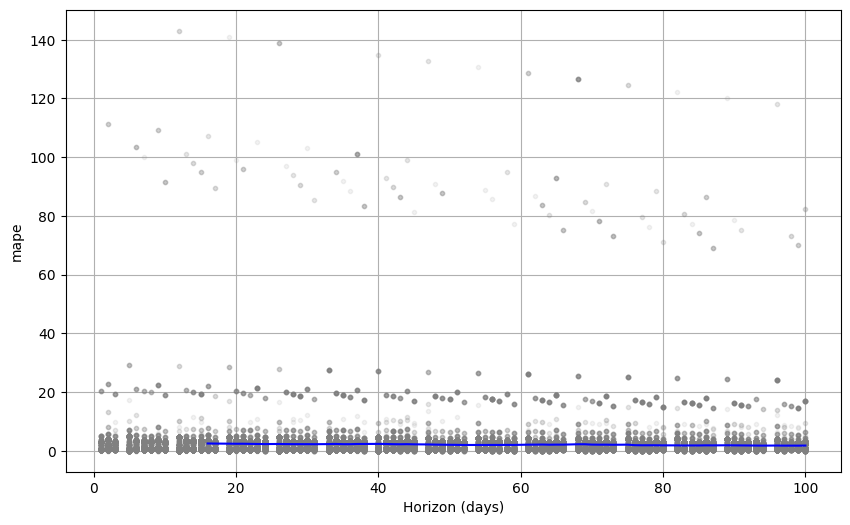

In [32]:
#plot cross val
fig = plot_cross_validation_metric(df_cv, metric='mape')